In [1]:
import keras
keras.__version__


/home/paperspace/anaconda3/envs/fastai/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.4'

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os



from matplotlib import pyplot as plt
%matplotlib inline

import random

In [3]:
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/paperspace/data/GTSRB'

train_dir = os.path.join(base_dir, 'train')
valid_dir = os.path.join(base_dir, 'valid')
test_dir = os.path.join(base_dir, 'test')



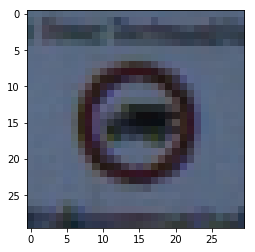

In [4]:
import glob
from PIL import Image


images=glob.glob(os.path.join(train_dir,"*/*.ppm"))
# for i in range(1:
#     img = Image.open(image)
#     img1 = img.resize(50,50)
#     img1.save("newfolder\\"+image)    


img=Image.open(images[0])
plt.imshow(np.asarray(img))

16016


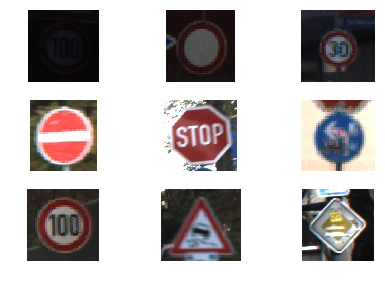

In [5]:
print(len(images))

for i in range(0,9):
    index = random.randint(0, len(images))
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    img = Image.open(images[index])
    plt.imshow(np.asarray(img))
#Show the plot
plt.subplots_adjust(top=0.92, bottom=0.05, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.50)

plt.show()

In [6]:
datagen = ImageDataGenerator( rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')
batch_size = 9
default_gen=datagen.flow_from_directory(train_dir,batch_size=9,target_size=(72,72),
                                        shuffle=True,class_mode=None)

np.random.seed(21)
sample_default=next(default_gen)
sample_default.shape

Found 16016 images belonging to 43 classes.


(9, 72, 72, 3)

(72, 72, 3)


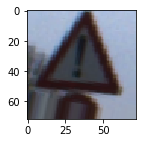

In [7]:
image = sample_default[0]
print(image.shape)

plt.figure(figsize=(2,2))
plt.imshow(image)
# print(y_train[index]

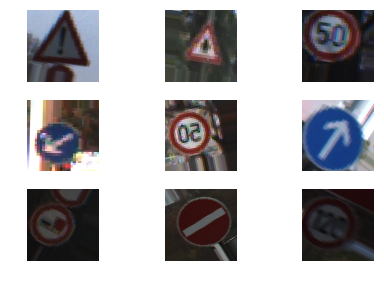

In [8]:
for i in range(9):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(sample_default[i])
#Show the plot
plt.subplots_adjust(top=0.92, bottom=0.05, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.50)

plt.show()

In [5]:
from keras.applications import VGG16
from keras import models
from keras import layers
from keras import optimizers
# define early stopping callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.models import load_model

In [6]:


conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(72,72,3))

In [7]:
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 72, 72, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 72, 72, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 72, 72, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 36, 36, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 36, 36, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 36, 36, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

In [12]:


model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(43, activation='sigmoid'))

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               524544    
_________________________________________________________________
dense_2 (Dense)              (None, 43)                11051     
Total params: 15,250,283
Trainable params: 15,250,283
Non-trainable params: 0
_________________________________________________________________


In [8]:


train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

valid_datagen= ImageDataGenerator(rescale=1./255)


In [9]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

In [10]:
train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(72, 72),
        batch_size=20,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='categorical')


validation_generator = valid_datagen.flow_from_directory(
        valid_dir,
        target_size=(72, 72),
        batch_size=20,
        class_mode='categorical')

# Found 16016 images belonging to 43 classes.
# Found 7972 images belonging to 43 classes.

Found 16016 images belonging to 43 classes.
Found 7972 images belonging to 43 classes.


In [17]:


outputFolder = './output-signs'
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)
filepath=outputFolder+"/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, \
                             save_best_only=False, save_weights_only=True, \
                             mode='auto', period=10)

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/30
 - 20s - loss: 3.3307 - acc: 0.1165 - val_loss: 2.7844 - val_acc: 0.1940
Epoch 2/30
 - 17s - loss: 2.4743 - acc: 0.2605 - val_loss: 2.1145 - val_acc: 0.3560
Epoch 3/30
 - 17s - loss: 2.0036 - acc: 0.3885 - val_loss: 1.6901 - val_acc: 0.4460
Epoch 4/30
 - 17s - loss: 1.7347 - acc: 0.4575 - val_loss: 1.4526 - val_acc: 0.5260
Epoch 5/30
 - 17s - loss: 1.4913 - acc: 0.5165 - val_loss: 1.2657 - val_acc: 0.5850
Epoch 6/30
 - 17s - loss: 1.3075 - acc: 0.5650 - val_loss: 1.0902 - val_acc: 0.6540
Epoch 7/30
 - 18s - loss: 1.1940 - acc: 0.6159 - val_loss: 0.9993 - val_acc: 0.6710
Epoch 8/30
 - 17s - loss: 1.0772 - acc: 0.6425 - val_loss: 0.7622 - val_acc: 0.7258
Epoch 9/30
 - 17s - loss: 0.9171 - acc: 0.7005 - val_loss: 0.7321 - val_acc: 0.7590
Epoch 10/30
 - 17s - loss: 0.8800 - acc: 0.6915 - val_loss: 0.6829 - val_acc: 0.7770
Epoch 11/30
 - 17s - loss: 0.7936 - acc: 0.7355 - val_loss: 0.5661 - val_acc: 0.8100
Epoch 12/30
 - 17s - loss: 0.7370 - acc: 0.7505 - val_loss: 0.5992 - val_a

In [18]:
from keras.models import load_model

# # Creates a HDF5 file 'my_model.h5'
# model.save('vgg_model_pre.h5')

# Save the weights
model.save_weights('vgg_model_pre.h5')

# Save the model architecture
with open('vgg_model_pre_architecture.json', 'w') as f:
    f.write(model.to_json())

In [4]:
#  load the model 
from keras.models import model_from_json

# Model reconstruction from JSON file
with open('vgg_model_pre_architecture.json', 'r') as f:
    model = model_from_json(f.read())

# Load weights into the new model
model.load_weights('vgg_model_pre.h5')


In [11]:
# Use fine tuning
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

earlystop = EarlyStopping(monitor='val_acc', min_delta=0.0001, patience=5, \
                          verbose=1, mode='auto')
callbacks_list = [earlystop]

history = model.fit_generator(
      train_generator,
      steps_per_epoch=100,
      epochs=30,
      callbacks=callbacks_list,
      validation_data=validation_generator,
      validation_steps=50)

Epoch 1/30
100/100 [==============================] - 19s 194ms/step - loss: 0.2702 - acc: 0.9130 - val_loss: 0.1768 - val_acc: 0.9320
Epoch 2/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2459 - acc: 0.9220 - val_loss: 0.2079 - val_acc: 0.9360
Epoch 3/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2456 - acc: 0.9210 - val_loss: 0.1159 - val_acc: 0.9610
Epoch 4/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2107 - acc: 0.9290 - val_loss: 0.1764 - val_acc: 0.9410
Epoch 5/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2414 - acc: 0.9235 - val_loss: 0.1593 - val_acc: 0.9500
Epoch 6/30
100/100 [==============================] - 17s 169ms/step - loss: 0.2286 - acc: 0.9215 - val_loss: 0.1282 - val_acc: 0.9580
Epoch 7/30
100/100 [==============================] - 18s 178ms/step - loss: 0.2073 - acc: 0.9259 - val_loss: 0.1955 - val_acc: 0.9300
Epoch 8/30
100/100 [==============================] - 1

In [13]:
from keras.models import load_model

# # Creates a HDF5 file 'my_model.h5'
# model.save('vgg_model_pre.h5')

# Save the weights
model.save_weights('vgg_model_finetune.h5')

# Save the model architecture
with open('vgg_model_finetune.json', 'w') as f:
    f.write(model.to_json())

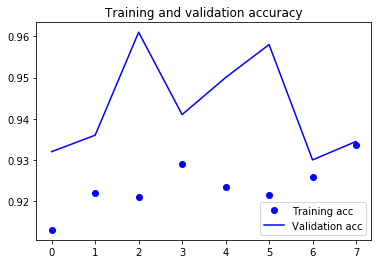

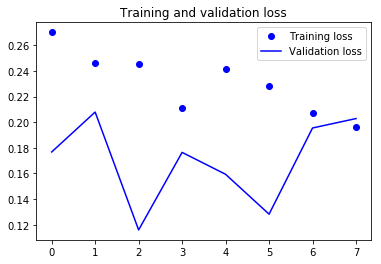

In [14]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [15]:
test_datagen=ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(72, 72),
        batch_size=20,
        class_mode='categorical')

test_loss, test_acc = model.evaluate_generator(test_generator, steps=50)
print('test acc:', test_acc)

Found 2652 images belonging to 43 classes.
test acc: 0.948999992609024


In [ ]:

### Load the images and plot them here.
### Feel free to use as many code cells as needed.

labels=np.stack((1,21,29,33,35))
images = []
filenames= ['./testdata/image1.jpg','./testdata/image2.jpg','./testdata/image3.jpg','./testdata/image4.jpg','./testdata/image5.jpg']

for filename in filenames:
    image = Image.open(filename)
    
    images.append(image)

images

# np.expand_dims(images_array, axis=2)
plt.figure(figsize=(1,1))
plt.imshow(images[0])
print(images[0])

In [16]:
sample_dir=os.path.join(base_dir,'testdata')
sample_images =  [i for i in os.listdir(sample_dir)]

ROWS = 72
COLS = 72
CHANNELS = 3

In [17]:
len(sample_images)

5

In [58]:
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img


def read_image(file_path,dir):
    img = cv2.imread(os.path.join(dir,file_path), cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images,dir):
    count = len(images)
    data = np.ndarray((count, ROWS, COLS,CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        x = load_img(os.path.join(dir,images[i]), target_size=(72,72))
        x = img_to_array(x)
        x = np.expand_dims(x, axis=0)
        data[i] = x
#         if i%2500 == 0: print('Processed {} of {}'.format(i, count))
    
    return data

In [59]:
sample = prep_data(sample_images,sample_dir)

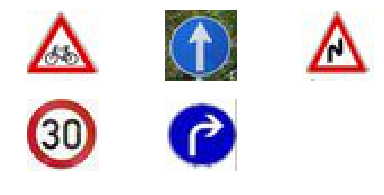

In [60]:

# labels=np.stack((1,21,29,33,35))
for i in range(5):
    plt.subplot(330 + 1 + i)
    plt.axis('off')
    plt.imshow(sample[i])
#Show the plot
plt.subplots_adjust(top=0.92, bottom=0.05, left=0.10, right=0.95, hspace=0.25,
                  wspace=0.50)

plt.show()

In [61]:
print("Sample shape: {}".format(sample.shape))

Sample shape: (5, 72, 72, 3)


In [62]:
labels=[29,35,21,1,33]
n_labels=43
sample_labels=np.eye(n_labels)[labels]

In [63]:
sample_labels[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [64]:
sample=sample/255

test_loss,test_accuracy = model.evaluate(sample,sample_labels,verbose=1)
print(" Accuracy for new web images",test_accuracy)

5/5 [==============================] - 0s 4ms/step
 Accuracy for new web images 0.800000011920929


In [51]:
x=sample[1]
x=x/255.
y_hat = model.predict(np.expand_dims(x, axis=0))